# Transformer model fitting

This notebook contains the fitting of the Transformer model to all series in the dataset at the same time.

In [1]:
import os
import sys
import pickle
import pandas as pd
import matplotlib.pyplot as plt

src_path = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))
sys.path.append(src_path)

from Transformers.model_selection import TransformerHyperTune
from Transformers.data_processing import window_dataset_sequence_to_sequence
from DataSimulation.utils import plot_fit

In [2]:
data = pd.read_csv('data.csv', header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,2.0,173.0,143.0,11.0,2.0,937.0,81.0,52.0,27.0,20.0,...,11.0,43.0,15.0,56.0,155.0,1.0,2.0,3.0,82.0,8.0
1,1.0,267.0,104.0,3.0,2.0,43.0,36.0,7.0,23.0,10.0,...,12.0,4.0,8.0,28.0,13.0,0.0,7.0,4.0,65.0,10.0
2,5.0,102.0,73.0,12.0,1.0,714.0,35.0,44.0,29.0,3.0,...,16.0,22.0,29.0,42.0,13.0,0.0,1.0,3.0,87.0,20.0
3,11.0,115.0,100.0,5.0,0.0,2662.0,15.0,38.0,22.0,10.0,...,12.0,15.0,16.0,67.0,9.0,1.0,2.0,3.0,67.0,28.0
4,0.0,73.0,137.0,9.0,0.0,1063.0,73.0,77.0,29.0,5.0,...,10.0,24.0,13.0,25.0,45.0,4.0,1.0,1.0,79.0,26.0


In [3]:
test_size = 4*24
train_data = data.iloc[:-test_size, :].to_numpy()
test_data = data.iloc[-test_size:, :].to_numpy()
print(train_data.shape)
print(test_data.shape)

(904, 100)
(96, 100)


In [4]:
parameters = {
    "num_layers":[2],
    "num_heads":[4,6],
    "dff":[8,16,32],
    "dropout_rate":[0.1,0.3],
    "learning_rate":[0.01, 0.001],
    "batch_size":[8,16,32]
}

In [5]:
transformer_hypertune = TransformerHyperTune(
    num_features=100,
    window_size=24,
    parameters=parameters
)

In [6]:
transformer_model, scaler = transformer_hypertune.fit(
    data=train_data,
    checkpoint_path=os.path.join(os.getcwd(), 'checkpoint'),
    epochs=500
)

Training model 0/72.
minimum 0 model's validation loss: 0.021211061626672745.
Training model 1/72.
minimum 1 model's validation loss: 0.021211164072155952.
Training model 2/72.
minimum 2 model's validation loss: 0.021209150552749634.
Training model 3/72.
minimum 3 model's validation loss: 0.02139228954911232.
Training model 4/72.
minimum 4 model's validation loss: 0.021301772445440292.
Training model 5/72.
minimum 5 model's validation loss: 0.021249821409583092.
Training model 6/72.
minimum 6 model's validation loss: 0.021224165335297585.
Training model 7/72.
minimum 7 model's validation loss: 0.021209025755524635.
Training model 8/72.
minimum 8 model's validation loss: 0.021193016320466995.
Training model 9/72.
minimum 9 model's validation loss: 0.021378817036747932.
Training model 10/72.
minimum 10 model's validation loss: 0.021279683336615562.
Training model 11/72.
minimum 11 model's validation loss: 0.021264255046844482.
Training model 12/72.
minimum 12 model's validation loss: 0.0

time: 715m, 23.3s

In [7]:
transformer_hypertune.best_params

{'num_layers': 2,
 'num_heads': 4,
 'dff': 8,
 'dropout_rate': 0.3,
 'learning_rate': 0.01,
 'batch_size': 32}

In [9]:
scaled_data = scaler.transform(data)

In [10]:
eval_ds = window_dataset_sequence_to_sequence(
    data=scaled_data,
    sequence_lenght=24,
    output_lenght=24,
    batch_size=scaled_data.shape[0],
    shift=1,
    shuffle=False    
)

In [11]:
fit_values = transformer_model.predict(eval_ds)
fit_0 = fit_values[:,0,:]

1/1 [==============================] - 2s 2s/step


In [12]:
orig_scale = scaler.inverse_transform(fit_0)

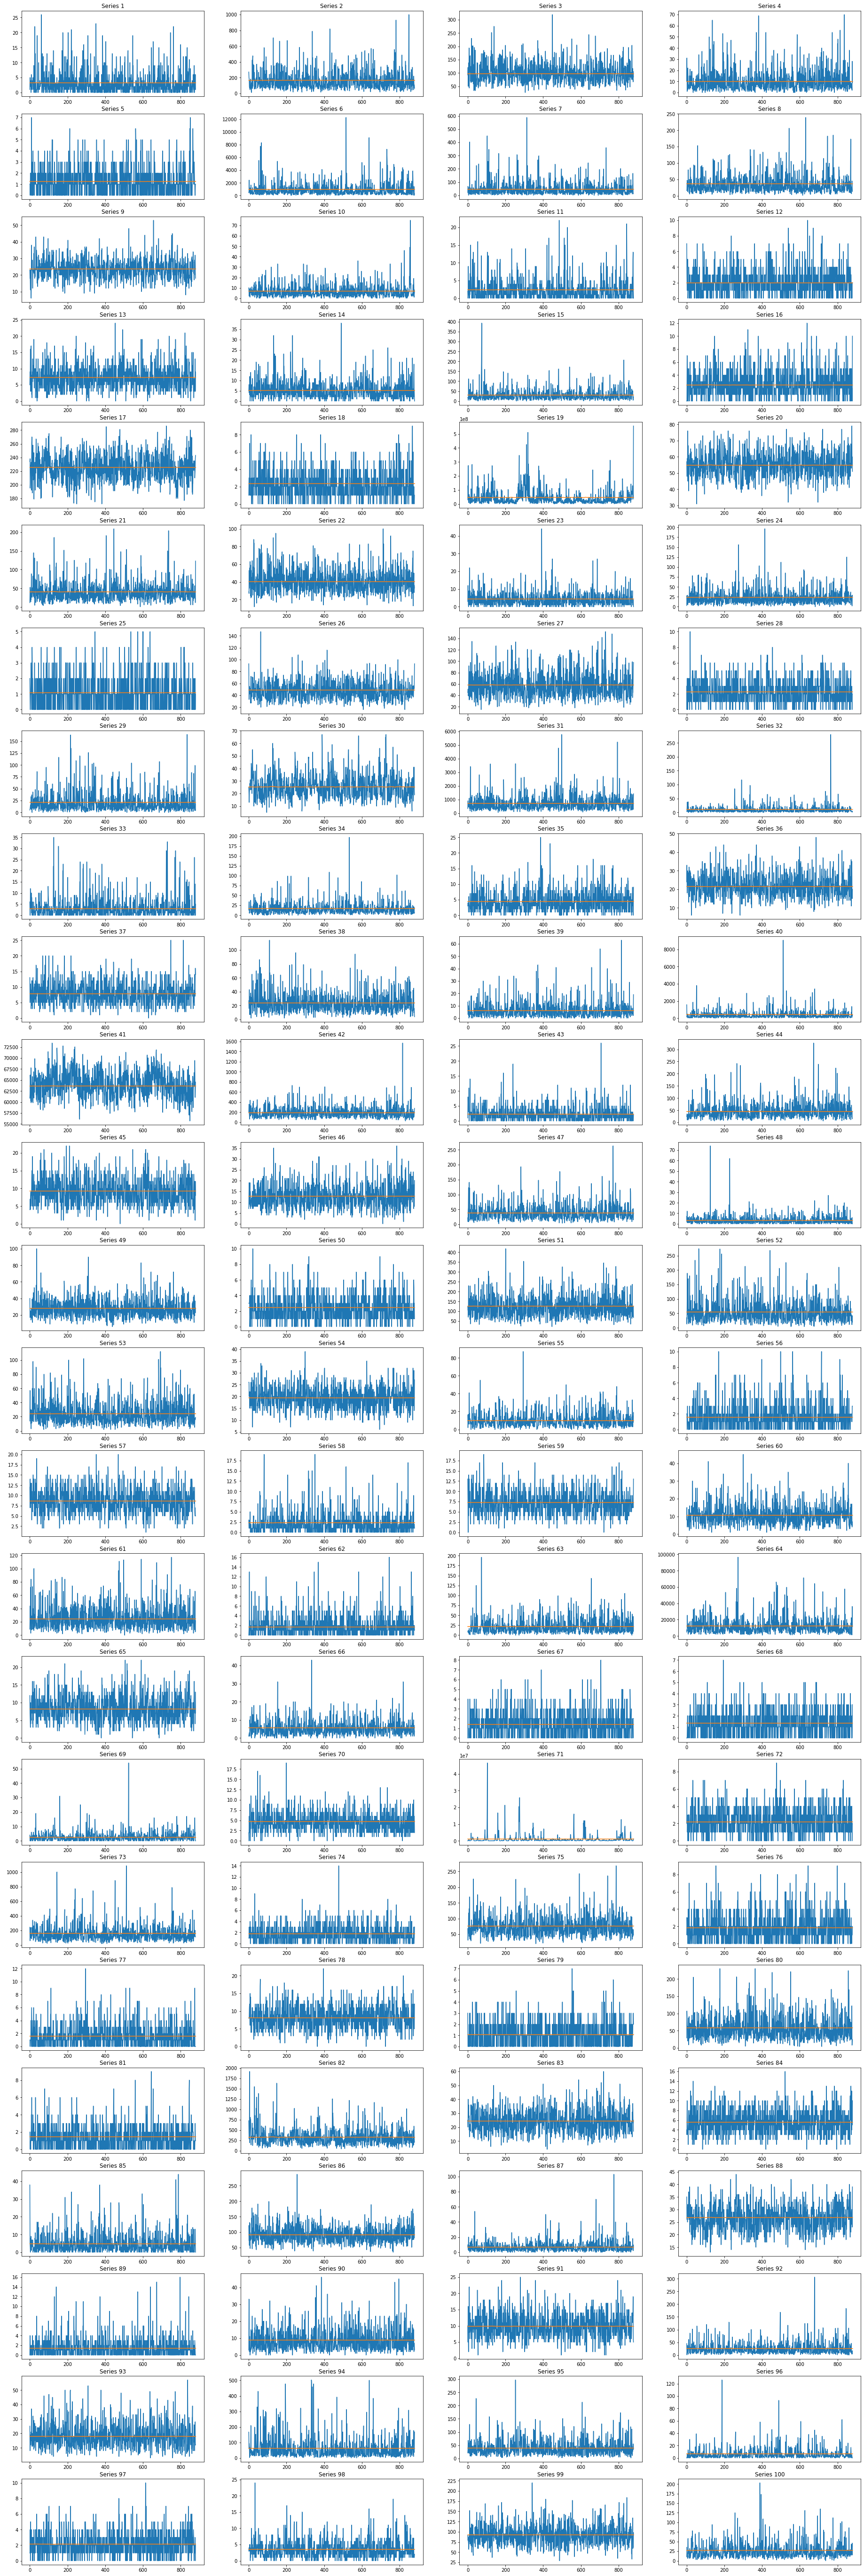

In [13]:
plot_fit(train_data[24:], orig_scale[:-3*24], cols=4)

In [14]:
transformer_model.summary()

Model: "transformer_73"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_73 (Encoder)        multiple                  327016    
                                                                 
 decoder_73 (Decoder)        multiple                  650016    
                                                                 
 dense_665 (Dense)           multiple                  10100     
                                                                 
Total params: 987,132
Trainable params: 987,132
Non-trainable params: 0
_________________________________________________________________


In [15]:
transformer_model.save("transformer.tf")

INFO:tensorflow:Assets written to: transformer.tf\assets


INFO:tensorflow:Assets written to: transformer.tf\assets


In [16]:
transformer_model.save_weights('transformer_weights/transformer')

In [17]:
with open("transformer_scaler.pkl", "wb") as file:
    pickle.dump(scaler, file)